# Image Classification for 

### 1. Import dependencies

In [2]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl
from pytorch_lightning import LightningDataModule, LightningModule, Trainer, seed_everything
from torchvision.models import resnet34, ResNet34_Weights, resnet50, ResNet50_Weights, vgg16, VGG16_Weights, vgg16_bn, VGG16_BN_Weights
from torchvision import transforms
from PIL import Image
from torch.optim import Adam
import torch.nn as nn
import numpy as np
import os
import pandas as pd

from datasets import load_dataset

/home/oem/miniconda3/envs/skin_cancer/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2. Load dataset (Hugging Face)

dataset was previously uploaded to huggingface. Please see upload_to_huggingface folder for workbook how-to.

In [3]:
dataset = load_dataset("marmal88/skin_cancer")
dataset.set_format(type='torch', columns=['image', 'image_id', 'lesion_id', 'dx', 'dx_type', 'age', 'sex', 'localization'])

# print to get the names of the sets within the dataset
print(dataset.__getitem__)

Using custom data configuration marmal88--skin_cancer-4d80d9330324f110
Found cached dataset parquet (/home/oem/.cache/huggingface/datasets/marmal88___parquet/marmal88--skin_cancer-4d80d9330324f110/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 3/3 [00:00<00:00, 90.63it/s]

<bound method DatasetDict.__getitem__ of DatasetDict({
    train: Dataset({
        features: ['image', 'image_id', 'lesion_id', 'dx', 'dx_type', 'age', 'sex', 'localization'],
        num_rows: 9577
    })
    test: Dataset({
        features: ['image', 'image_id', 'lesion_id', 'dx', 'dx_type', 'age', 'sex', 'localization'],
        num_rows: 1285
    })
    validation: Dataset({
        features: ['image', 'image_id', 'lesion_id', 'dx', 'dx_type', 'age', 'sex', 'localization'],
        num_rows: 2492
    })
})>


### 2. Load dataset from file

In [4]:
os.chdir('..')
os.getcwd()

'/home/oem/Documents/coding/personal/skin_cancer'

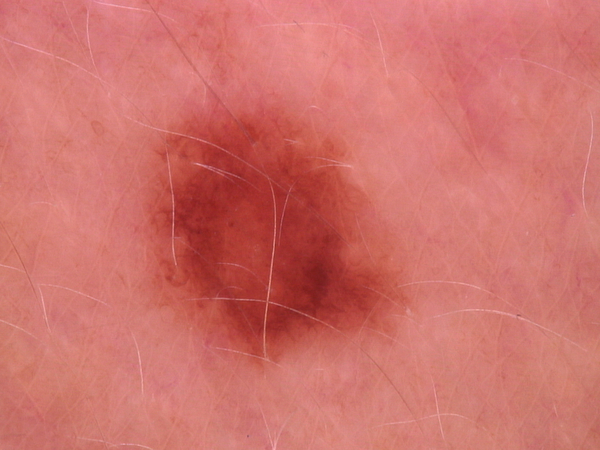

In [5]:
data = pd.read_csv(os.path.join(os.getcwd(), "notebooks/dataset.csv"))
Image.open(os.path.join(os.getcwd(), data["file_name"][1]))

In [6]:
df = pd.read_csv(os.path.join(os.getcwd(), "notebooks/dataset.csv"))
len(df)

10015

In [7]:
# dataset class
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, transform=None):
        self.data = pd.read_csv(os.path.join(os.getcwd(), "notebooks/dataset.csv"))
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data["file_name"].iloc[idx]
        image = Image.open(img_path)
        self.label = self.data["dx"].iloc[idx]
        if self.transform:
            sample = self.transform(image)
        return {"image": sample, "label": self.label}

In [8]:
transform = transforms.Compose([
                transforms.Resize([224,224]),
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
            ])

dataset = CustomImageDataset(os.path.join(os.getcwd(), "notebooks/dataset.csv"), transform)

train_set, val_set, test_set = torch.utils.data.random_split(dataset, [8000, 2000, 15])

### 3. Transform original dataset

In [9]:
# load the respective train validation and test split to dataloader
train_loader = DataLoader(train_set, batch_size=7, shuffle=True)
val_loader = DataLoader(val_set, batch_size=7, shuffle=True)
test_loader = DataLoader(test_set, batch_size=7, shuffle=True)

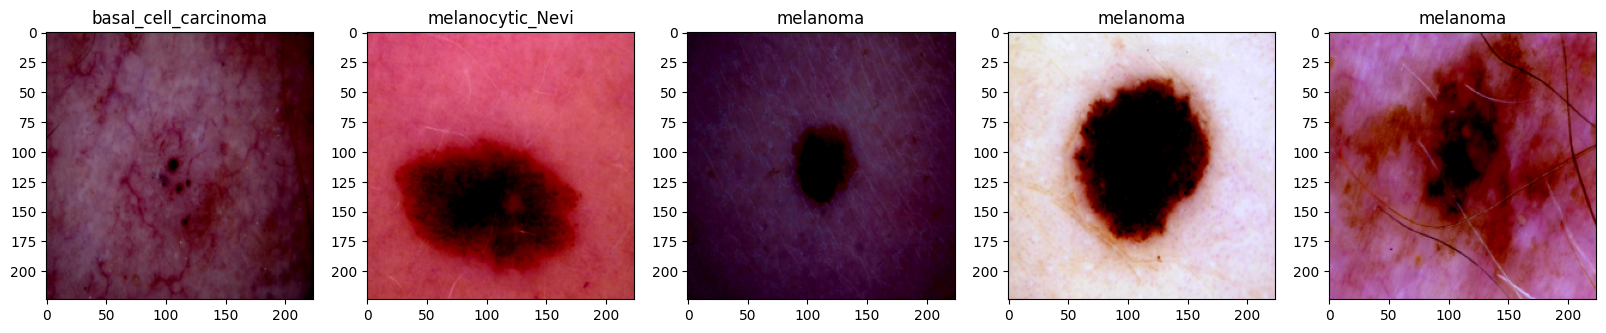

In [10]:
plt.figure(figsize=(20,20))

# viewing test dataset
# show the first image of the first 5 batches
for i in range(0, 5):
    batch = next(iter(train_loader))
    img, label = batch['image'], batch['label']
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(label[1])
    # As original image has been converted to tensor and thus have a range greater than 0,255 colours may appear different
    img_tensor = torch.permute(img[1], (1,2,0))
    plt.imshow(np.clip(img_tensor, 0,255))
plt.show()

### Using Pytorch Lightning

According to the offical PyTorch Lightning documentation, pl.model is organized into 5 main sections:

1. Computations (init).
2. Optimizers and LR Schedulers (configure_optimizers)
3. Train Loop (training_step)
4. Validation Loop (validation_step)
5. Test Loop (test_step)
6. Prediction Loop (predict_step)

In [13]:
# model
def get_model():
    num_cat = 7
    model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

    first_conv_layer = [nn.Conv2d(7, 224, kernel_size=3, stride=1, padding=0, dilation=1, groups=1, bias=True)]
    first_conv_layer.extend(list(model.features)) 
    model.features= nn.Sequential(*first_conv_layer) 

    # Given groups=1, weight of size [3, 7, 3, 3], expected input[7, 3, 224, 224]
    # Given groups=7, weight of size [224, 32, 3, 3], expected input[7, 3, 224, 224]

    model.classifier[-1] = nn.Linear(4096, 1000)
    model.classifier.add_module('7', nn.ReLU())
    model.classifier.add_module('8', nn.Dropout(p=0.5, inplace=False))
    model.classifier.add_module('9', nn.Linear(1000, num_cat))
    model.classifier.add_module('10', nn.LogSoftmax(dim=1))

    for param in model.parameters():
        param.require_grad = False
    return model


class ClassifierModel(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.model = get_model()
        self.loss = nn.CrossEntropyLoss

    def forward(self, imgs):
        return self.model(imgs)

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=0.001)
    
    def training_step(self, batch, batch_idx):
        imgs, labels = batch['image'], batch['label'] 
        preds = self.model(imgs)
        loss = self.loss_module(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()
        return loss

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch['image'], batch['label'] 
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()

In [14]:
trainer = Trainer(max_epochs=100)
trainer.fit(ClassifierModel(), train_loader, val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type | Params
-------------------------------
0 | model | VGG  | 138 M 
-------------------------------
138 M     Trainable params
0         Non-trainable params
138 M     Total params
553.717   Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

RuntimeError: Given groups=7, weight of size [224, 32, 3, 3], expected input[7, 3, 224, 224] to have 224 channels, but got 3 channels instead